#Preprocesamiento común a XGBoost y FCNN


In [ ]:
# Paso 0: Instalar dependencias necesarias
!pip install biopython xgboost scikit-learn pandas matplotlib transformers sentencepiece torch --quiet

# Paso 1: Importar librerías
import pandas as pd
import numpy as np
from Bio.PDB import PDBList, PDBParser, PPBuilder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from xgboost import XGBRegressor
import os
import matplotlib.pyplot as plt
import torch
from transformers import T5Tokenizer, T5EncoderModel

# Paso 2: Cargar dataset
df = pd.read_csv("s2648.csv")
df[['wt_res', 'position', 'mut_res']] = df['MUT'].str.extract(r'([A-Z])(\d+)([A-Z])')
df['position'] = df['position'].astype(int)

# Paso 3: Descargar estructuras PDB y extraer secuencias de cadenas
pdbl = PDBList()
pdb_dir = "/content/pdbs"
os.makedirs(pdb_dir, exist_ok=True)

sequence_dict = {}
unique_pdbs = df[['PDB', 'CHAIN']].drop_duplicates()
parser = PDBParser(QUIET=True)
ppb = PPBuilder()

for idx, row in unique_pdbs.iterrows():
    pdb_id = row['PDB'].lower()
    chain_id = row['CHAIN']
    try:
        pdb_file = pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format='pdb')
        structure = parser.get_structure(pdb_id, pdb_file)
        for model in structure:
            if chain_id in model:
                chain = model[chain_id]
                peptides = ppb.build_peptides(chain)
                if peptides:
                    sequence = ''.join([str(p.get_sequence()) for p in peptides])
                    sequence_dict[(row['PDB'], chain_id)] = str(sequence)
    except Exception as e:
        print(f"⚠️ Error con {pdb_id} cadena {chain_id}: {e}")

# Paso 4: Inicializar modelo ProtT5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_bfd").to(device).eval()

@torch.no_grad()
def get_embedding_prott5(sequence, position):
    seq = ' '.join(list(sequence))
    ids = tokenizer(seq, return_tensors="pt", add_special_tokens=True)
    input_ids = ids["input_ids"].to(device)
    attention_mask = ids["attention_mask"].to(device)
    embedding = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.squeeze(0)
    emb_pos = embedding[position + 1].cpu().numpy()
    return emb_pos

# Propiedades adicionales
def net_volume(wild, mutation):
    vol = {'A':88.6,'R':173.4,'N':114.1,'D':111.1,'C':108.5,'E':138.4,'Q':143.8,'G':60.1,'H':153.2,
           'I':166.7,'L':166.7,'K':168.6,'M':162.9,'F':189.9,'P':112.7,'S':89.0,'T':116.1,'W':227.8,
           'Y':193.6,'V':140.0}
    return float(vol.get(mutation, 0) - vol.get(wild, 0))

def net_hydrophobicity(wild, mutation):
    hyd = {'A':0,'R':3.71,'N':3.47,'D':2.95,'C':0.49,'E':1.64,'Q':3.01,'G':1.72,'H':4.76,'I':-1.56,
           'L':-1.81,'K':5.39,'M':-0.76,'F':-2.2,'P':-1.52,'S':1.83,'T':1.78,'W':-0.38,'Y':-1.09,
           'V':-0.78}
    return float(hyd.get(mutation, 0) - hyd.get(wild, 0))

def flexibility(wild, mutation):
    flex = {'A':1,'R':81,'N':36,'D':18,'C':3,'E':54,'Q':108,'G':1,'H':36,'I':9,'L':9,'K':81,
            'M':27,'F':18,'P':2,'S':3,'T':3,'W':36,'Y':18,'V':3}
    return flex.get(mutation, 0) - flex.get(wild, 0)

def mutation_type(wild, mutation):
    wild_list = ['A','F','C','D','N','E','Q','G','H','L','I','K','M','P','R','S','T','V','W','Y']
    mutation_list = ['A','F','C','D','N','E','Q','G','H','L','I','K','M','P','R','S','T','V','W','Y']
    label = 0
    for i in wild_list:
        for j in mutation_list:
            if i != j:
                label += 1
                if wild == i and mutation == j:
                    return label
    return 0

# Crear carpeta para embeddings
emb_dir = "/content/embeddings"
os.makedirs(emb_dir, exist_ok=True)

def extract_features_with_neighbors(df, sequence_dict):
    features = []
    valid_indices = []
    for idx, row in df.iterrows():
        wt, mt = row['wt_res'], row['mut_res']
        pos = row['position'] - 1
        pdb, chain = row['PDB'], row['CHAIN']
        seq = sequence_dict.get((pdb, chain), "")
        if not seq or pos < 0 or pos >= len(seq):
            continue

        vec = [ord(wt) - ord('A'), ord(mt) - ord('A'), pos, pos / len(seq)]
        window = 7
        neighbor_counts = [0] * 20

        for offset in range(-window, window + 1):
            if offset == 0:
                continue
            i = pos + offset
            if 0 <= i < len(seq):
                aa = seq[i]
                aa_index = ord(aa) - ord('A')
                vec.append(aa_index)
                if 0 <= aa_index < 20:
                    neighbor_counts[aa_index] += 1
            else:
                vec.append(-1)

        vec.extend(neighbor_counts)
        vec.append(net_volume(wt, mt))
        vec.append(net_hydrophobicity(wt, mt))
        vec.append(flexibility(wt, mt))
        vec.append(mutation_type(wt, mt))

        try:
            emb_path = os.path.join(emb_dir, f"{pdb}_{chain}_{pos}.npy")
            if os.path.exists(emb_path):
                emb = np.load(emb_path)
            else:
                emb = get_embedding_prott5(seq, pos)
                np.save(emb_path, emb)
            vec.extend(emb.tolist())
        except:
            continue

        features.append(vec)
        valid_indices.append(idx)

    return np.array(features), valid_indices

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.4 MB/s eta 0:00:00
Structure exists: '/content/pdbs/pdb1luc.ent' 
Desired structure doesn't exist
⚠️ Error con 2a01 cadena A: [Errno 2] No such file or directory: '/content/pdbs/pdb2a01.ent'


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

#Modelo XGBoost

➡️ Usando 2647 de 2648 mutaciones con secuencia real disponible
🔁 Fold 1: PCC=0.688, MSE=1.115, MAE=0.812


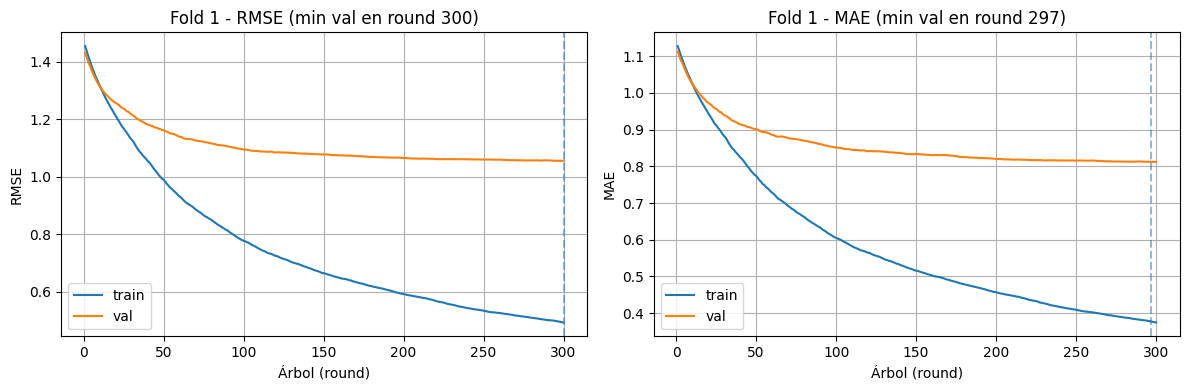

🔁 Fold 2: PCC=0.700, MSE=1.139, MAE=0.814


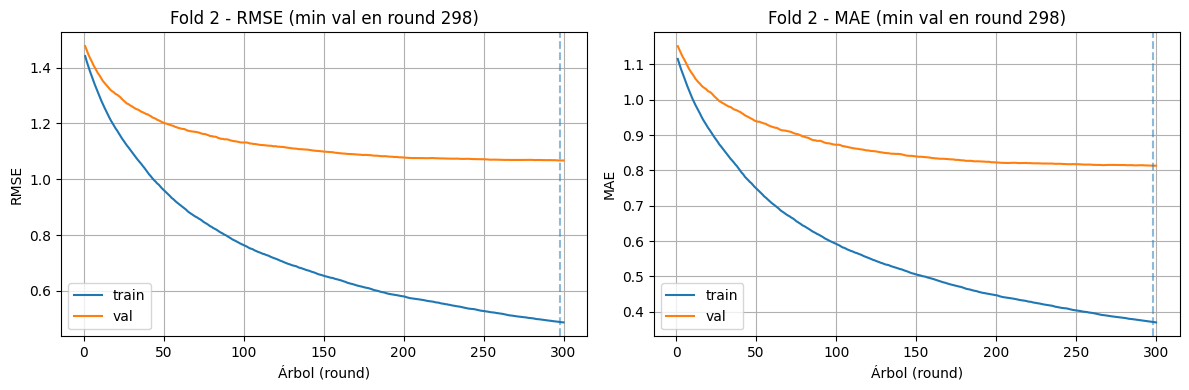

🔁 Fold 3: PCC=0.668, MSE=1.284, MAE=0.849


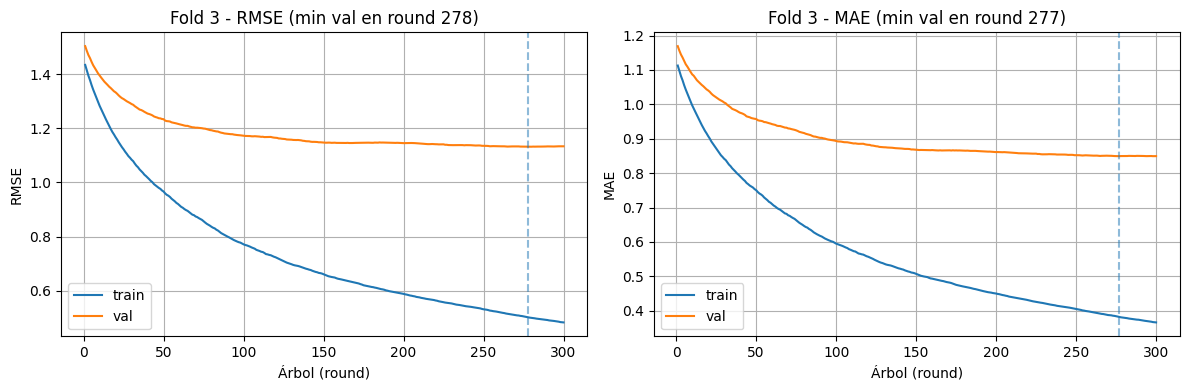

🔁 Fold 4: PCC=0.584, MSE=1.358, MAE=0.900


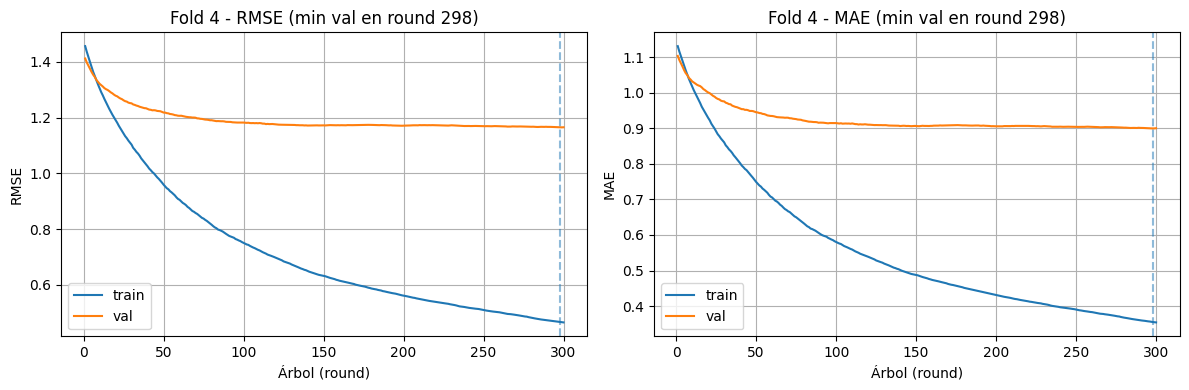

🔁 Fold 5: PCC=0.658, MSE=1.205, MAE=0.823


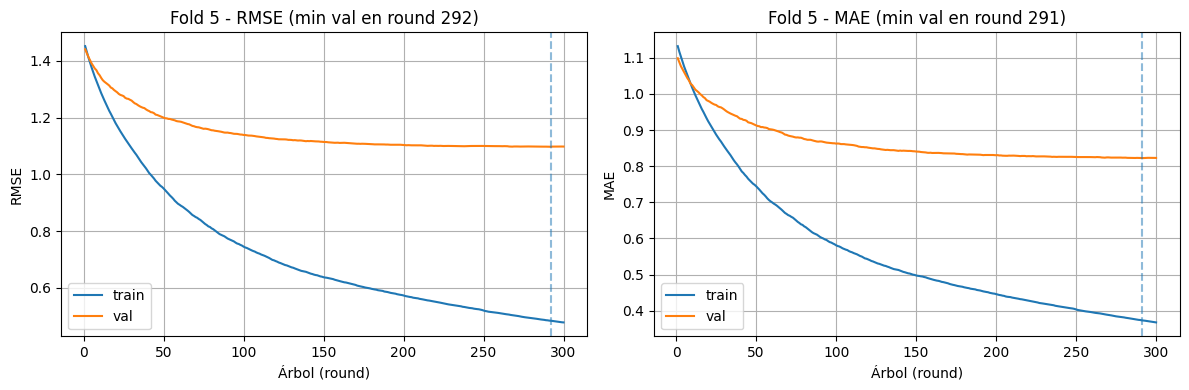


📊 Resultados promedio (5-Fold CV):
📉 MSE: 1.220 ± 0.090
🖏 MAE: 0.840 ± 0.033
🔗 PCC: 0.660 ± 0.041

📌 Evaluación en 20% test set fijo con curvas de entrenamiento
📉 MSE: 1.070
🖏 MAE: 0.783
🔗 PCC: 0.703


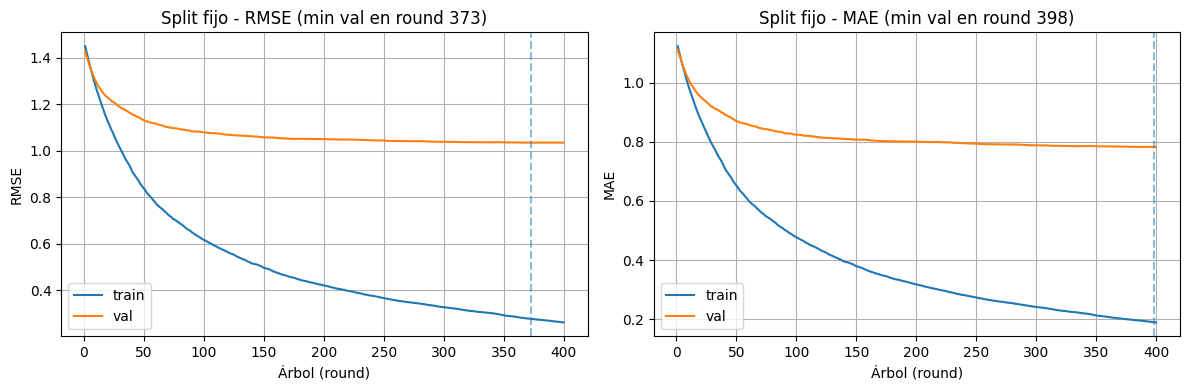

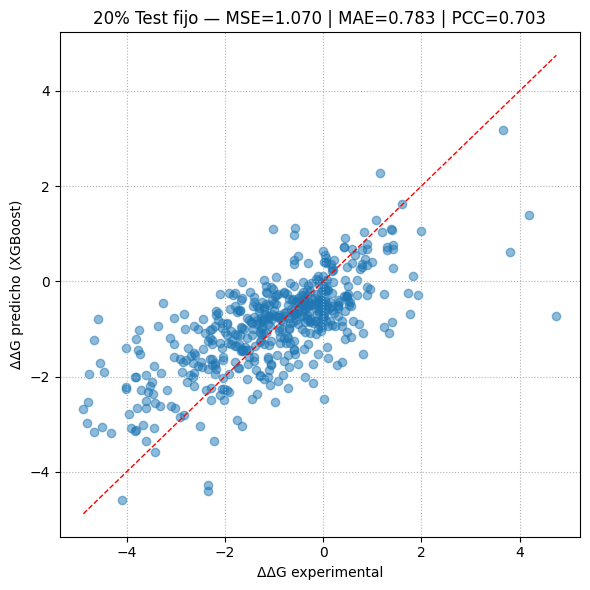

In [ ]:
# Paso 5: Preparar datos y aplicar KFold con escalado
df_filtered = df[df.apply(lambda row: (row['PDB'], row['CHAIN']) in sequence_dict, axis=1)].copy()
df_filtered = df_filtered.reset_index(drop=True)
print(f"➡️ Usando {len(df_filtered)} de {len(df)} mutaciones con secuencia real disponible")

X, valid_idx = extract_features_with_neighbors(df_filtered, sequence_dict)
df_valid = df_filtered.iloc[valid_idx]
y = df_valid['DDG'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# ================================
# K-Fold con logging y gráficas de loss (RMSE/MAE)
# ================================
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list, mae_list, pcc_list = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=42,
        eval_metric=['rmse', 'mae']
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )

    # Métricas del fold
    y_pred = model.predict(X_test)
    mse_list.append(mean_squared_error(y_test, y_pred))
    mae_list.append(mean_absolute_error(y_test, y_pred))
    pcc_list.append(pearsonr(y_test, y_pred)[0])
    print(f"🔁 Fold {fold+1}: PCC={pcc_list[-1]:.3f}, MSE={mse_list[-1]:.3f}, MAE={mae_list[-1]:.3f}")

    # 📈 Curvas por boosting round
    res = model.evals_result()
    rounds = np.arange(1, len(res['validation_0']['rmse']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # RMSE
    axes[0].plot(rounds, res['validation_0']['rmse'], label='train')
    axes[0].plot(rounds, res['validation_1']['rmse'], label='val')
    best_rmse_round = int(np.argmin(res['validation_1']['rmse'])) + 1
    axes[0].axvline(best_rmse_round, ls='--', alpha=0.5)
    axes[0].set_title(f'Fold {fold+1} - RMSE (min val en round {best_rmse_round})')
    axes[0].set_xlabel('Árbol (round)')
    axes[0].set_ylabel('RMSE')
    axes[0].grid(True); axes[0].legend()

    # MAE
    if 'mae' in res['validation_0'] and 'mae' in res['validation_1']:
        axes[1].plot(rounds, res['validation_0']['mae'], label='train')
        axes[1].plot(rounds, res['validation_1']['mae'], label='val')
        best_mae_round = int(np.argmin(res['validation_1']['mae'])) + 1
        axes[1].axvline(best_mae_round, ls='--', alpha=0.5)
        axes[1].set_title(f'Fold {fold+1} - MAE (min val en round {best_mae_round})')
        axes[1].set_xlabel('Árbol (round)')
        axes[1].set_ylabel('MAE')
        axes[1].grid(True); axes[1].legend()
    else:
        axes[1].axis('off')
        axes[1].set_title('MAE no disponible en esta versión')

    plt.tight_layout()
    plt.show()

print("\n📊 Resultados promedio (5-Fold CV):")
print(f"📉 MSE: {np.mean(mse_list):.3f} ± {np.std(mse_list):.3f}")
print(f"🖏 MAE: {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"🔗 PCC: {np.mean(pcc_list):.3f} ± {np.std(pcc_list):.3f}")

# ================================
# Split fijo 80/20 con curvas de loss (RMSE/MAE)
# ================================
print("\n📌 Evaluación en 20% test set fijo con curvas de entrenamiento")
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

final_model = XGBRegressor(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42,
    eval_metric=['rmse', 'mae']
)

final_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_train_split, y_train_split), (X_test_split, y_test_split)],
    verbose=False
)

y_pred_split = final_model.predict(X_test_split)
mse_split = mean_squared_error(y_test_split, y_pred_split)
mae_split = mean_absolute_error(y_test_split, y_pred_split)
pcc_split = pearsonr(y_test_split, y_pred_split)[0]

print(f"📉 MSE: {mse_split:.3f}")
print(f"🖏 MAE: {mae_split:.3f}")
print(f"🔗 PCC: {pcc_split:.3f}")

# 📈 Curvas del split fijo
res_final = final_model.evals_result()
rounds_final = np.arange(1, len(res_final['validation_0']['rmse']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# RMSE
axes[0].plot(rounds_final, res_final['validation_0']['rmse'], label='train')
axes[0].plot(rounds_final, res_final['validation_1']['rmse'], label='val')
best_rmse_round = int(np.argmin(res_final['validation_1']['rmse'])) + 1
axes[0].axvline(best_rmse_round, ls='--', alpha=0.5)
axes[0].set_title(f'Split fijo - RMSE (min val en round {best_rmse_round})')
axes[0].set_xlabel('Árbol (round)'); axes[0].set_ylabel('RMSE')
axes[0].grid(True); axes[0].legend()

# MAE
if 'mae' in res_final['validation_0'] and 'mae' in res_final['validation_1']:
    axes[1].plot(rounds_final, res_final['validation_0']['mae'], label='train')
    axes[1].plot(rounds_final, res_final['validation_1']['mae'], label='val')
    best_mae_round = int(np.argmin(res_final['validation_1']['mae'])) + 1
    axes[1].axvline(best_mae_round, ls='--', alpha=0.5)
    axes[1].set_title(f'Split fijo - MAE (min val en round {best_mae_round})')
    axes[1].set_xlabel('Árbol (round)'); axes[1].set_ylabel('MAE')
    axes[1].grid(True); axes[1].legend()
else:
    axes[1].axis('off')
    axes[1].set_title('MAE no disponible en esta versión')

plt.tight_layout()
plt.show()

# ================================
# 📊 NUEVO: Gráfico predicho vs experimental (test fijo 80/20)
# ================================
plt.figure(figsize=(6,6))
plt.scatter(y_test_split, y_pred_split, alpha=0.5)
mi, ma = np.min([y_test_split, y_pred_split]), np.max([y_test_split, y_pred_split])
plt.plot([mi, ma], [mi, ma], 'r--', linewidth=1)
plt.xlabel("ΔΔG experimental")
plt.ylabel("ΔΔG predicho (XGBoost)")
plt.title(f"20% Test fijo — MSE={mse_split:.3f} | MAE={mae_split:.3f} | PCC={pcc_split:.3f}")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


#Modelo final FCNN

🔁 Fold 1: PCC=0.601, MSE=1.375, MAE=0.879
🔁 Fold 2: PCC=0.660, MSE=1.265, MAE=0.846
🔁 Fold 3: PCC=0.624, MSE=1.440, MAE=0.896
🔁 Fold 4: PCC=0.590, MSE=1.402, MAE=0.900
🔁 Fold 5: PCC=0.595, MSE=1.377, MAE=0.880

📊 Resultados promedio (5-Fold CV):
📉 MSE: 1.372 ± 0.058
🖏 MAE: 0.880 ± 0.019
🔗 PCC: 0.614 ± 0.026

📌 Evaluación en 20% test set fijo:
📉 MSE: 1.387
🖏 MAE: 0.895
🔗 PCC: 0.596


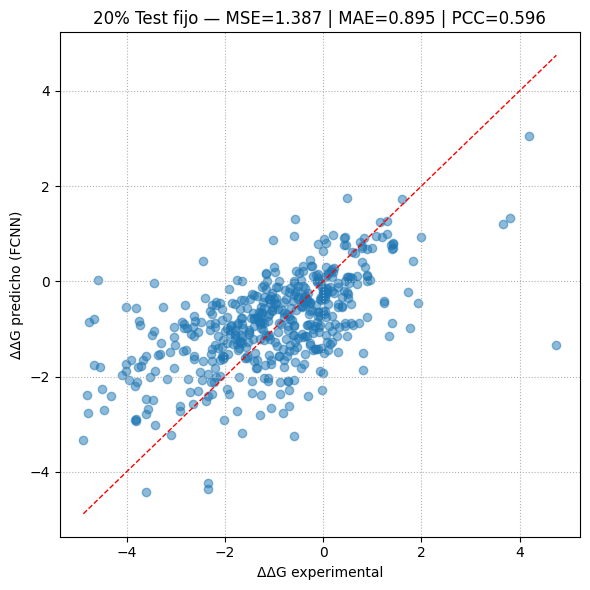

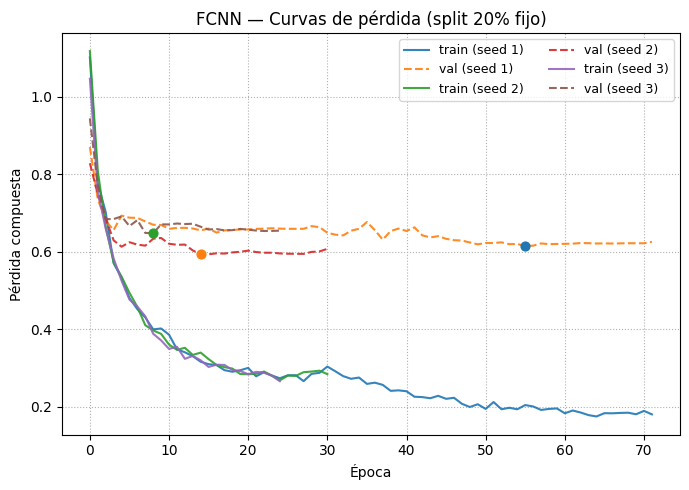

In [ ]:
# Paso 5: Preparar datos y aplicar KFold con escalado
df_filtered = df[df.apply(lambda row: (row['PDB'], row['CHAIN']) in sequence_dict, axis=1)].copy()
df_filtered = df_filtered.reset_index(drop=True)
print(f"➡️ Usando {len(df_filtered)} de {len(df)} mutaciones con secuencia real disponible")

X, valid_idx = extract_features_with_neighbors(df_filtered, sequence_dict)
df_valid = df_filtered.iloc[valid_idx]
y = df_valid['DDG'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
# ================================
# FCNN — KFold(5) + Test fijo 20% (con kNN meta-feature, pérdida compuesta y CosineDecayRestarts)
# Ahora con registro y gráficas de pérdida (train/val)
# ================================
import os, random, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks, initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

# -------------------------------------------------
# 0) Config
# -------------------------------------------------
SEEDS = [42, 7, 1337]
TEST_SIZE     = 0.20
VAL_SIZE      = 0.10          # % del train para validación
BATCH_SIZE    = 128
EPOCHS        = 250
L2_REG        = 1e-5
DROPOUT       = 0.40
KNN_NEIGHBORS = 28
# pérdida compuesta (y entrenada en z-score ⇒ std target ≈ 1)
W_MSE, W_CORR, W_STD = 0.50, 0.45, 0.05

# ¿Quieres ver curvas también por fold? (opcional)
PLOT_CV_CURVES = False   # pon True si quieres dibujar las de cada fold

# -------------------------------------------------
# 1) Utilidades reproducibilidad
# -------------------------------------------------
def set_global_seed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass

# -------------------------------------------------
# 2) kNN meta-feature OOF (sin fuga)
# -------------------------------------------------
def knn_oof_feature(Xtr, ytr, Xte, n_neighbors=KNN_NEIGHBORS, n_splits=5, seed=42):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = np.zeros(len(Xtr), dtype=np.float32)
    for tr_idx, va_idx in kf.split(Xtr):
        xtr, xva = Xtr[tr_idx], Xtr[va_idx]
        ytr_     = ytr[tr_idx]
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="distance", metric="euclidean")
        knn.fit(xtr, ytr_)
        oof[va_idx] = knn.predict(xva).astype(np.float32)
    knn_full = KNeighborsRegressor(n_neighbors=n_neighbors, weights="distance", metric="euclidean")
    knn_full.fit(Xtr, ytr)
    te_pred = knn_full.predict(Xte).astype(np.float32)
    return oof.reshape(-1,1), te_pred.reshape(-1,1)

# -------------------------------------------------
# 3) Pérdida compuesta + métrica PCC
# -------------------------------------------------
@tf.function
def pcc_metric(y_true, y_pred, eps=tf.constant(1e-8, tf.float32)):
    y_true_c = y_true - tf.reduce_mean(y_true)
    y_pred_c = y_pred - tf.reduce_mean(y_pred)
    cov  = tf.reduce_mean(y_true_c * y_pred_c)
    stdt = tf.sqrt(tf.reduce_mean(tf.square(y_true_c)) + eps)
    stdp = tf.sqrt(tf.reduce_mean(tf.square(y_pred_c)) + eps)
    return tf.clip_by_value(cov / (stdt * stdp + eps), -1.0, 1.0)

def make_composite_loss(w_mse=W_MSE, w_corr=W_CORR, w_std=W_STD):
    @tf.function
    def loss_fn(y_true, y_pred):
        mse  = tf.reduce_mean(tf.square(y_true - y_pred))
        r    = pcc_metric(y_true, y_pred)
        corr = 1.0 - tf.square(r)
        stdp = tf.math.reduce_std(y_pred)
        stdt = tf.square(stdp - 1.0)
        return w_mse*mse + w_corr*corr + w_std*stdt
    return loss_fn

# -------------------------------------------------
# 4) Modelo MLP (arquitectura fija, sin grid)
# -------------------------------------------------
def build_mlp(input_dim: int, seed: int):
    init = initializers.GlorotUniform(seed=seed)
    x_in = layers.Input(shape=(input_dim,))
    x    = layers.LayerNormalization()(x_in)

    x = layers.Dense(320, kernel_initializer=init,
                     kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.Activation("swish")(x)
    x = layers.Dropout(DROPOUT, seed=seed)(x)

    x = layers.Dense(384, kernel_initializer=init,
                     kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.Activation("swish")(x)
    x = layers.Dropout(DROPOUT, seed=seed)(x)

    x = layers.Dense(256, kernel_initializer=init,
                     kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = layers.Activation("swish")(x)

    y_out = layers.Dense(1, kernel_initializer=init)(x)
    model = models.Model(x_in, y_out)

    lr_sched = CosineDecayRestarts(
        initial_learning_rate=5e-4, first_decay_steps=400, t_mul=1.5, m_mul=0.9, alpha=1e-5
    )
    opt = Adam(learning_rate=lr_sched, clipnorm=1.0)

    model.compile(optimizer=opt,
                  loss=make_composite_loss(W_MSE, W_CORR, W_STD),
                  metrics=["mae", pcc_metric])
    return model

# -------------------------------------------------
# Helper para pintar histories
# -------------------------------------------------
def plot_histories(histories, title="Entrenamiento FCNN (loss)"):
    """histories: lista de dicts con claves 'loss' y 'val_loss' (uno por seed)."""
    plt.figure(figsize=(7,5))
    for i, h in enumerate(histories, 1):
        tr = h.get("loss", [])
        va = h.get("val_loss", [])
        plt.plot(tr, label=f"train (seed {i})", alpha=0.9)
        plt.plot(va, '--', label=f"val (seed {i})", alpha=0.9)
        if len(va) > 0:
            best = int(np.argmin(va))
            plt.scatter([best], [va[best]], marker='o', s=40, zorder=3)
    plt.xlabel("Época")
    plt.ylabel("Pérdida compuesta")
    plt.title(title)
    plt.grid(True, linestyle=':')
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# 5) Entrenar y predecir (con ensemble opcional) — devuelve también histories
# -------------------------------------------------
def fit_and_predict_FCNN(X_tr_in, y_tr_in, X_te_in, seeds=SEEDS, val_size=VAL_SIZE, return_histories=False):
    # kNN meta-feature (OOF en train; pred en test) usando SOLO X_tr_in/y_tr_in
    knn_tr, knn_te = knn_oof_feature(X_tr_in, y_tr_in, X_te_in, n_neighbors=KNN_NEIGHBORS, seed=42)
    mf_scaler = StandardScaler().fit(knn_tr)
    knn_tr_s = mf_scaler.transform(knn_tr).astype(np.float32)
    knn_te_s = mf_scaler.transform(knn_te).astype(np.float32)
    X_tr = np.hstack([X_tr_in, knn_tr_s]).astype(np.float32)
    X_te = np.hstack([X_te_in, knn_te_s]).astype(np.float32)

    # y en z-score (solo con TRAIN)
    y_scaler = StandardScaler().fit(y_tr_in.reshape(-1,1))
    y_tr = y_scaler.transform(y_tr_in.reshape(-1,1)).astype(np.float32).ravel()

    # split explícito de validación a partir del TRAIN
    X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(X_tr, y_tr, test_size=val_size, random_state=42)

    preds_te_all = []
    histories = []  # <- guardamos el history de cada seed
    for sd in seeds:
        set_global_seed(sd)
        model = build_mlp(input_dim=X_tr.shape[1], seed=sd)
        cb_early = callbacks.EarlyStopping(monitor="val_loss", patience=16, restore_best_weights=True)
        cb_nan   = callbacks.TerminateOnNaN()

        h = model.fit(
            X_tr_sub, y_tr_sub,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            shuffle=True,
            callbacks=[cb_early, cb_nan],
            verbose=0
        )

        # guardamos su history (como dict simple)
        histories.append({k: list(v) for k, v in h.history.items()})

        y_te_s = model.predict(X_te, batch_size=BATCH_SIZE, verbose=0).ravel()
        y_te   = y_scaler.inverse_transform(y_te_s.reshape(-1,1)).ravel()
        preds_te_all.append(y_te)

    # Ensemble por media si hay varias seeds
    y_pred_te = np.mean(np.vstack(preds_te_all), axis=0) if len(preds_te_all) > 1 else preds_te_all[0]
    if return_histories:
        return y_pred_te, histories
    return y_pred_te

# ======================================================
# 6) 5-Fold Cross-Validation (sobre X_scaled, y)
# (si PLOT_CV_CURVES=True, se dibujan las curvas del primer fold)
# ======================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list, mae_list, pcc_list = [], [], []

fold = 0
first_fold_histories = None
for tr_idx, te_idx in kf.split(X_scaled):
    fold += 1
    X_tr_fold, X_te_fold = X_scaled[tr_idx], X_scaled[te_idx]
    y_tr_fold, y_te_fold = y[tr_idx], y[te_idx]

    if PLOT_CV_CURVES and first_fold_histories is None:
        y_pred_fold, hists = fit_and_predict_FCNN(X_tr_fold, y_tr_fold, X_te_fold,
                                                  seeds=SEEDS, val_size=VAL_SIZE, return_histories=True)
        first_fold_histories = hists
    else:
        y_pred_fold = fit_and_predict_FCNN(X_tr_fold, y_tr_fold, X_te_fold,
                                           seeds=SEEDS, val_size=VAL_SIZE, return_histories=False)

    mse = mean_squared_error(y_te_fold, y_pred_fold)
    mae = mean_absolute_error(y_te_fold, y_pred_fold)
    pcc = pearsonr(y_te_fold, y_pred_fold)[0] if len(np.unique(y_pred_fold))>1 else 0.0

    mse_list.append(mse); mae_list.append(mae); pcc_list.append(pcc)
    print(f"🔁 Fold {fold}: PCC={pcc:.3f}, MSE={mse:.3f}, MAE={mae:.3f}")

print("\n📊 Resultados promedio (5-Fold CV):")
print(f"📉 MSE: {np.mean(mse_list):.3f} ± {np.std(mse_list):.3f}")
print(f"🖏 MAE: {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"🔗 PCC: {np.mean(pcc_list):.3f} ± {np.std(pcc_list):.3f}")

# (Opcional) Mostrar curvas del primer fold
if PLOT_CV_CURVES and first_fold_histories is not None:
    plot_histories(first_fold_histories, title="FCNN — Curvas de pérdida (primer fold)")

# ======================================================
# 7) Test fijo 20% (mismo esquema que tu XGBoost)
# ======================================================
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=42
)
y_pred_split, split_histories = fit_and_predict_FCNN(
    X_train_split, y_train_split, X_test_split, seeds=SEEDS, val_size=VAL_SIZE, return_histories=True
)

mse_split = mean_squared_error(y_test_split, y_pred_split)
mae_split = mean_absolute_error(y_test_split, y_pred_split)
pcc_split = pearsonr(y_test_split, y_pred_split)[0] if len(np.unique(y_pred_split))>1 else 0.0

print("\n📌 Evaluación en 20% test set fijo:")
print(f"📉 MSE: {mse_split:.3f}")
print(f"🖏 MAE: {mae_split:.3f}")
print(f"🔗 PCC: {pcc_split:.3f}")

# Gráfico de dispersión (test fijo)
plt.figure(figsize=(6,6))
plt.scatter(y_test_split, y_pred_split, alpha=0.5)
mi, ma = np.min([y_test_split, y_pred_split]), np.max([y_test_split, y_pred_split])
plt.plot([mi, ma], [mi, ma], 'r--', linewidth=1)
plt.xlabel("ΔΔG experimental")
plt.ylabel("ΔΔG predicho (FCNN)")
plt.title(f"20% Test fijo — MSE={mse_split:.3f} | MAE={mae_split:.3f} | PCC={pcc_split:.3f}")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

# ====> NUEVO: Curvas de pérdida del split fijo (una por seed)
plot_histories(split_histories, title="FCNN — Curvas de pérdida (split 20% fijo)")


#Modelo final QNN

Structure exists: '/mnt/data/pdbs\pdb1fvk.ent' 
Structure exists: '/mnt/data/pdbs\pdb1a43.ent' 
Structure exists: '/mnt/data/pdbs\pdb1a5e.ent' 
Structure exists: '/mnt/data/pdbs\pdb1ihb.ent' 
Structure exists: '/mnt/data/pdbs\pdb1otr.ent' 
Structure exists: '/mnt/data/pdbs\pdb1ubq.ent' 
Structure exists: '/mnt/data/pdbs\pdb1cse.ent' 
Structure exists: '/mnt/data/pdbs\pdb1ag2.ent' 
Structure exists: '/mnt/data/pdbs\pdb1aky.ent' 
Structure exists: '/mnt/data/pdbs\pdb1ank.ent' 
Structure exists: '/mnt/data/pdbs\pdb1am7.ent' 
Structure exists: '/mnt/data/pdbs\pdb1amq.ent' 
Structure exists: '/mnt/data/pdbs\pdb1aon.ent' 
Structure exists: '/mnt/data/pdbs\pdb1aps.ent' 
Structure exists: '/mnt/data/pdbs\pdb1arr.ent' 
Structure exists: '/mnt/data/pdbs\pdb1azp.ent' 
Structure exists: '/mnt/data/pdbs\pdb1sso.ent' 
Structure exists: '/mnt/data/pdbs\pdb1b26.ent' 
Structure exists: '/mnt/data/pdbs\pdb1b8e.ent' 
Structure exists: '/mnt/data/pdbs\pdb1bni.ent' 
Structure exists: '/mnt/data/pdbs\pdb1bo

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


epoch 01 | val_combo=0.4689 (Huber=0.3073, 1-r^2=0.7202, std1=0.2357) | PCC≈0.529 | 1296.6s
epoch 02 | val_combo=0.4561 (Huber=0.3002, 1-r^2=0.7038, std1=0.1898) | PCC≈0.544 | 1342.5s
epoch 03 | val_combo=0.4537 (Huber=0.2986, 1-r^2=0.6997, std1=0.1927) | PCC≈0.548 | 1325.5s
epoch 04 | val_combo=0.4425 (Huber=0.2928, 1-r^2=0.6836, std1=0.1609) | PCC≈0.562 | 1257.5s
epoch 05 | val_combo=0.4395 (Huber=0.2901, 1-r^2=0.6788, std1=0.1694) | PCC≈0.567 | 1317.9s
epoch 06 | val_combo=0.4410 (Huber=0.2915, 1-r^2=0.6795, std1=0.1762) | PCC≈0.566 | 1323.5s
epoch 07 | val_combo=0.4429 (Huber=0.2907, 1-r^2=0.6863, std1=0.1703) | PCC≈0.560 | 1284.9s
epoch 08 | val_combo=0.4443 (Huber=0.2910, 1-r^2=0.6878, std1=0.1830) | PCC≈0.559 | 1370.4s
epoch 09 | val_combo=0.4417 (Huber=0.2891, 1-r^2=0.6837, std1=0.1831) | PCC≈0.562 | 1333.9s
epoch 10 | val_combo=0.4415 (Huber=0.2906, 1-r^2=0.6839, std1=0.1634) | PCC≈0.562 | 1283.2s
⏹ early stopping
🔁 Fold 1: PCC=0.567, MSE=1.339, MAE=0.927


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


epoch 01 | val_combo=0.5110 (Huber=0.3432, 1-r^2=0.7729, std1=0.2608) | PCC≈0.477 | 1284.9s
epoch 02 | val_combo=0.5033 (Huber=0.3411, 1-r^2=0.7650, std1=0.1931) | PCC≈0.485 | 1200.3s
epoch 03 | val_combo=0.4950 (Huber=0.3368, 1-r^2=0.7526, std1=0.1731) | PCC≈0.497 | 1355.3s
epoch 04 | val_combo=0.4939 (Huber=0.3363, 1-r^2=0.7515, std1=0.1653) | PCC≈0.498 | 1312.0s
epoch 05 | val_combo=0.4947 (Huber=0.3359, 1-r^2=0.7526, std1=0.1782) | PCC≈0.497 | 1307.4s
epoch 06 | val_combo=0.4930 (Huber=0.3346, 1-r^2=0.7484, std1=0.1919) | PCC≈0.502 | 1282.7s
epoch 07 | val_combo=0.4900 (Huber=0.3354, 1-r^2=0.7448, std1=0.1522) | PCC≈0.505 | 1271.9s
epoch 08 | val_combo=0.4883 (Huber=0.3336, 1-r^2=0.7414, std1=0.1644) | PCC≈0.508 | 1279.9s
epoch 09 | val_combo=0.4893 (Huber=0.3342, 1-r^2=0.7441, std1=0.1576) | PCC≈0.506 | 1272.5s
epoch 10 | val_combo=0.4859 (Huber=0.3330, 1-r^2=0.7373, std1=0.1580) | PCC≈0.513 | 1265.4s
epoch 11 | val_combo=0.4843 (Huber=0.3312, 1-r^2=0.7347, std1=0.1649) | PCC≈0.51

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


🔁 Fold 2: PCC=0.515, MSE=1.443, MAE=0.981
epoch 01 | val_combo=0.5166 (Huber=0.3592, 1-r^2=0.7657, std1=0.2548) | PCC≈0.484 | 1272.6s
epoch 02 | val_combo=0.5015 (Huber=0.3529, 1-r^2=0.7467, std1=0.1745) | PCC≈0.503 | 1270.7s
epoch 03 | val_combo=0.4943 (Huber=0.3482, 1-r^2=0.7361, std1=0.1674) | PCC≈0.514 | 1269.8s
epoch 04 | val_combo=0.4943 (Huber=0.3495, 1-r^2=0.7373, std1=0.1424) | PCC≈0.513 | 1276.9s
epoch 05 | val_combo=0.4917 (Huber=0.3464, 1-r^2=0.7338, std1=0.1537) | PCC≈0.516 | 1269.7s
epoch 06 | val_combo=0.4941 (Huber=0.3478, 1-r^2=0.7367, std1=0.1632) | PCC≈0.513 | 1268.3s
epoch 07 | val_combo=0.4912 (Huber=0.3475, 1-r^2=0.7322, std1=0.1440) | PCC≈0.517 | 1269.7s
epoch 08 | val_combo=0.4959 (Huber=0.3496, 1-r^2=0.7384, std1=0.1651) | PCC≈0.511 | 1271.7s
epoch 09 | val_combo=0.4892 (Huber=0.3450, 1-r^2=0.7297, std1=0.1508) | PCC≈0.520 | 1272.4s
epoch 10 | val_combo=0.4905 (Huber=0.3486, 1-r^2=0.7316, std1=0.1231) | PCC≈0.518 | 1273.2s
epoch 11 | val_combo=0.4955 (Huber=0.3

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


🔁 Fold 3: PCC=0.520, MSE=1.500, MAE=1.018
epoch 01 | val_combo=0.4963 (Huber=0.3167, 1-r^2=0.7749, std1=0.2428) | PCC≈0.474 | 1266.4s
epoch 02 | val_combo=0.4844 (Huber=0.3161, 1-r^2=0.7561, std1=0.1618) | PCC≈0.494 | 1288.0s
epoch 03 | val_combo=0.4788 (Huber=0.3120, 1-r^2=0.7481, std1=0.1576) | PCC≈0.502 | 1348.5s
epoch 04 | val_combo=0.4789 (Huber=0.3142, 1-r^2=0.7480, std1=0.1375) | PCC≈0.502 | 1301.5s
epoch 05 | val_combo=0.4771 (Huber=0.3109, 1-r^2=0.7456, std1=0.1581) | PCC≈0.504 | 1275.2s
epoch 06 | val_combo=0.4720 (Huber=0.3100, 1-r^2=0.7375, std1=0.1303) | PCC≈0.512 | 1248.6s
epoch 07 | val_combo=0.4725 (Huber=0.3088, 1-r^2=0.7384, std1=0.1450) | PCC≈0.511 | 1252.4s
epoch 08 | val_combo=0.4727 (Huber=0.3119, 1-r^2=0.7372, std1=0.1262) | PCC≈0.513 | 1286.7s
epoch 09 | val_combo=0.4767 (Huber=0.3126, 1-r^2=0.7448, std1=0.1366) | PCC≈0.505 | 1262.7s
epoch 10 | val_combo=0.4724 (Huber=0.3136, 1-r^2=0.7360, std1=0.1103) | PCC≈0.514 | 1264.2s
epoch 11 | val_combo=0.4739 (Huber=0.3

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


🔁 Fold 4: PCC=0.512, MSE=1.545, MAE=0.964
epoch 01 | val_combo=0.4891 (Huber=0.3264, 1-r^2=0.7562, std1=0.2140) | PCC≈0.494 | 1311.8s
epoch 02 | val_combo=0.4786 (Huber=0.3205, 1-r^2=0.7427, std1=0.1732) | PCC≈0.510 | 1298.3s
epoch 03 | val_combo=0.4727 (Huber=0.3179, 1-r^2=0.7340, std1=0.1643) | PCC≈0.519 | 1336.1s
epoch 04 | val_combo=0.4698 (Huber=0.3152, 1-r^2=0.7310, std1=0.1506) | PCC≈0.523 | 1277.0s
epoch 05 | val_combo=0.4665 (Huber=0.3139, 1-r^2=0.7262, std1=0.1474) | PCC≈0.528 | 1269.4s
epoch 06 | val_combo=0.4649 (Huber=0.3122, 1-r^2=0.7238, std1=0.1492) | PCC≈0.531 | 1320.8s
epoch 07 | val_combo=0.4637 (Huber=0.3114, 1-r^2=0.7219, std1=0.1477) | PCC≈0.533 | 1302.6s
epoch 08 | val_combo=0.4639 (Huber=0.3119, 1-r^2=0.7231, std1=0.1474) | PCC≈0.532 | 1287.3s
epoch 09 | val_combo=0.4623 (Huber=0.3107, 1-r^2=0.7204, std1=0.1471) | PCC≈0.535 | 1352.7s
epoch 10 | val_combo=0.4621 (Huber=0.3106, 1-r^2=0.7200, std1=0.1475) | PCC≈0.535 | 1291.6s
epoch 11 | val_combo=0.4620 (Huber=0.3

[seed 42] epoch 01 | val_combo=0.5092 (Huber=0.3118, 1-r^2=0.7967, std1=0.5748) | PCC≈0.451 | std(ŷ)≈0.242 | 1304.4s
[seed 42] epoch 02 | val_combo=0.4674 (Huber=0.2929, 1-r^2=0.7596, std1=0.2369) | PCC≈0.490 | std(ŷ)≈0.513 | 1294.3s
[seed 42] epoch 03 | val_combo=0.4628 (Huber=0.3008, 1-r^2=0.7506, std1=0.1230) | PCC≈0.499 | std(ŷ)≈0.649 | 1294.4s
[seed 42] epoch 04 | val_combo=0.4612 (Huber=0.2913, 1-r^2=0.7523, std1=0.1860) | PCC≈0.498 | std(ŷ)≈0.569 | 1296.4s
[seed 42] epoch 05 | val_combo=0.4615 (Huber=0.2870, 1-r^2=0.7506, std1=0.2536) | PCC≈0.499 | std(ŷ)≈0.496 | 1294.8s
[seed 42] epoch 06 | val_combo=0.4582 (Huber=0.2874, 1-r^2=0.7441, std1=0.2339) | PCC≈0.506 | std(ŷ)≈0.516 | 1298.8s
[seed 42] epoch 07 | val_combo=0.4486 (Huber=0.2829, 1-r^2=0.7299, std1=0.2007) | PCC≈0.520 | std(ŷ)≈0.552 | 1291.3s
[seed 42] epoch 08 | val_combo=0.4430 (Huber=0.2788, 1-r^2=0.7226, std1=0.1903) | PCC≈0.527 | std(ŷ)≈0.564 | 1291.2s
[seed 42] epoch 09 | val_combo=0.4437 (Huber=0.2784, 1-r

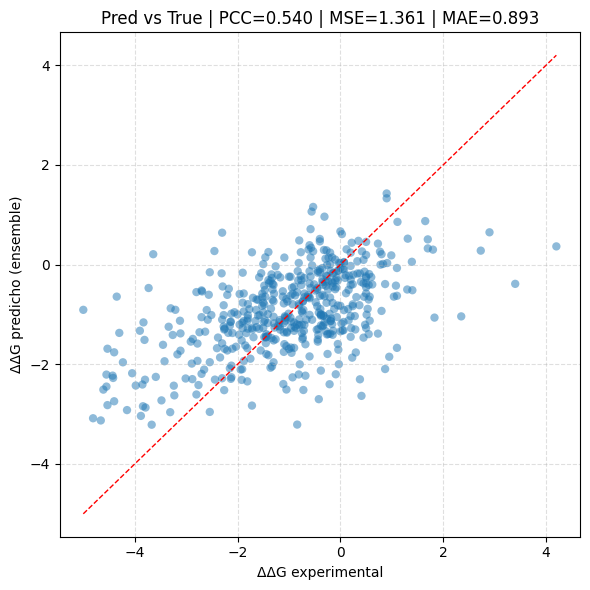

In [ ]:
# ================================
# QNN — 5-Fold CV + Test fijo 20% (mismo pipeline que XGB/FCNN)
# ================================
import sys, subprocess, os, math, time, random
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
    "qiskit>=1.2", "qiskit-aer>=0.15", "qiskit-machine-learning>=0.8",
    "torch>=2.0", "scikit-learn", "pandas", "numpy", "scipy", "biopython", "matplotlib"
])

import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, torch.nn as nn
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import pearsonr

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

from Bio.PDB import PDBList, PDBParser, PPBuilder

# -------------------------------
# Config
# -------------------------------
CSV_PATH               = "/mnt/data/s2648.csv" if os.path.exists("/mnt/data/s2648.csv") else "s2648.csv"
PDB_DIR                = "/mnt/data/pdbs"
SEQ_CACHE              = "/mnt/data/sequence_dict.npy"

N_SAMPLES              = None      # None => todo
TARGET_DIM             = 16        # 16–24 suelen ir bien; menos = más rápido
N_QUBITS               = 2         # 2 qubits = mucho más rápido/estable
BATCH_SIZE             = 64
MAX_EPOCHS             = 12        # CV corto; sube para test fijo si quieres (EPOCHS_TEST)
EPOCHS_TEST            = 18
PATIENCE               = 5
LR                     = 2e-3
WD                     = 1e-3
RUNS                   = 1         # ensemble por seeds (p.ej. 3) — más lento
SEEDS                  = [42]      # se usa cuando RUNS > 1
USE_CLASSICAL_SKIP     = True      # concatena salida QNN + rama clásica
USE_KNN_META_FEATURE   = True      # añade meta-feature kNN (OOF) a la rama clásica
FILTER_ONLY_HAS_SEQ    = True      # usa solo filas con secuencia real
SEQ_WINDOW             = 7         # ±k vecinos en secuencia para conteos
SEED_GLOBAL            = 42

# Pérdida compuesta (z-score en y ⇒ std target ≈ 1)
LAMBDA_HUBER           = 0.55
LAMBDA_PCC             = 0.40
LAMBDA_STD             = 0.05

# -------------------------------
# Reproducibilidad
# -------------------------------
def set_global_seed(sd=SEED_GLOBAL):
    os.environ["PYTHONHASHSEED"] = str(sd)
    random.seed(sd); np.random.seed(sd); torch.manual_seed(sd)

set_global_seed(SEED_GLOBAL)

# -------------------------------
# Cargar datos
# -------------------------------
df = pd.read_csv(CSV_PATH)
df[['wt_res','position','mut_res']] = df['MUT'].str.extract(r'([A-Z])(\d+)([A-Z])')
df['position'] = df['position'].astype(int)

# -------------------------------
# Descargar/extraer secuencias PDB (como XGB/FCNN)
# -------------------------------
def build_sequence_dict(df, pdb_dir=PDB_DIR):
    os.makedirs(pdb_dir, exist_ok=True)
    pdbl = PDBList()
    parser = PDBParser(QUIET=True)
    ppb = PPBuilder()
    seq_dict = {}
    for pdb, chain in df[['PDB','CHAIN']].drop_duplicates().itertuples(index=False):
        try:
            pdb_id = str(pdb).lower()
            pdb_file = pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format='pdb')
            structure = parser.get_structure(pdb_id, pdb_file)
            for model in structure:
                if chain in model:
                    ch = model[chain]
                    peptides = ppb.build_peptides(ch)
                    if peptides:
                        sequence = ''.join([str(p.get_sequence()) for p in peptides])
                        seq_dict[(pdb, chain)] = str(sequence)
        except Exception:
            pass
    return seq_dict

if os.path.exists(SEQ_CACHE):
    try:
        sequence_dict = np.load(SEQ_CACHE, allow_pickle=True).item()
    except Exception:
        sequence_dict = build_sequence_dict(df)
else:
    sequence_dict = build_sequence_dict(df)
    try:
        np.save(SEQ_CACHE, sequence_dict)
    except Exception:
        pass

# -------------------------------
# Features básicas + vecinos secuencia (sin ProtT5)
# -------------------------------
AA_VOL = {'A':88.6,'R':173.4,'N':114.1,'D':111.1,'C':108.5,'E':138.4,'Q':143.8,'G':60.1,'H':153.2,'I':166.7,'L':166.7,'K':168.6,'M':162.9,'F':189.9,'P':112.7,'S':89.0,'T':116.1,'W':227.8,'Y':193.6,'V':140.0}
AA_HYD = {'A':0,'R':3.71,'N':3.47,'D':2.95,'C':0.49,'E':1.64,'Q':3.01,'G':1.72,'H':4.76,'I':-1.56,'L':-1.81,'K':5.39,'M':-0.76,'F':-2.2,'P':-1.52,'S':1.83,'T':1.78,'W':-0.38,'Y':-1.09,'V':-0.78}
AA_FLEX= {'A':1,'R':81,'N':36,'D':18,'C':3,'E':54,'Q':108,'G':1,'H':36,'I':9,'L':9,'K':81,'M':27,'F':18,'P':2,'S':3,'T':3,'W':36,'Y':18,'V':3}
AA_LIST = ['A','F','C','D','N','E','Q','G','H','L','I','K','M','P','R','S','T','V','W','Y']; AA_TO_IDX20 = {a:i for i,a in enumerate(AA_LIST)}

def mutation_type_label(w, m):
    if w not in AA_LIST or m not in AA_LIST or w==m: return 0
    wi, mi = AA_LIST.index(w), AA_LIST.index(m)
    return wi*(len(AA_LIST)-1) + (mi - (1 if mi>wi else 0)) + 1

def basic_features_from_row(row):
    w, m, pos = row['wt_res'], row['mut_res'], int(row['position'])
    feat = [ord(w)-65, ord(m)-65, pos,
            AA_VOL.get(m,0)-AA_VOL.get(w,0),
            AA_HYD.get(m,0)-AA_HYD.get(w,0),
            AA_FLEX.get(m,0)-AA_FLEX.get(w,0),
            mutation_type_label(w,m)]
    onehot_w = [0]*20; onehot_m = [0]*20
    if w in AA_TO_IDX20: onehot_w[AA_TO_IDX20[w]] = 1
    if m in AA_TO_IDX20: onehot_m[AA_TO_IDX20[m]] = 1
    return feat + onehot_w + onehot_m

def neighbor_features_row(row, window=7):
    pdb, chain = row['PDB'], row['CHAIN']
    seq = sequence_dict.get((pdb, chain), "")
    if not seq: return None
    pos0 = int(row['position']) - 1
    if pos0 < 0 or pos0 >= len(seq): return None
    pos_norm = pos0 / max(1, (len(seq)-1))
    counts = np.zeros(20, dtype=np.float32)
    for off in range(-window, window+1):
        if off == 0: continue
        i = pos0 + off
        if 0 <= i < len(seq):
            aa = seq[i]
            if aa in AA_TO_IDX20:
                counts[AA_TO_IDX20[aa]] += 1.0
    return np.concatenate([[pos_norm], counts]).astype(np.float32)

X_basic = np.vstack([basic_features_from_row(r) for _, r in df.iterrows()]).astype(np.float32)
X_neigh, mask_has_seq = [], []
for _, r in df.iterrows():
    nf = neighbor_features_row(r, window=SEQ_WINDOW)
    mask_has_seq.append(nf is not None)
    X_neigh.append(nf if nf is not None else np.zeros(1+20, dtype=np.float32))
mask_has_seq = np.array(mask_has_seq, dtype=bool)
X_neigh = np.vstack(X_neigh).astype(np.float32)

X_tab = np.hstack([X_basic, X_neigh]).astype(np.float32)
y_all = df['DDG'].values.astype(np.float32)

if FILTER_ONLY_HAS_SEQ:
    X_tab = X_tab[mask_has_seq]; y_all = y_all[mask_has_seq]; df = df[mask_has_seq].reset_index(drop=True)

if N_SAMPLES is not None:
    idx = np.random.choice(len(X_tab), size=min(N_SAMPLES, len(X_tab)), replace=False)
    X_tab = X_tab[idx]; y_all = y_all[idx]; df = df.iloc[idx].reset_index(drop=True)

print("X_tab shape =", X_tab.shape, "| y shape =", y_all.shape)

# Escalado global + PCA (entrada QNN y rama clásica)
x_scaler_global = StandardScaler().fit(X_tab)
X_scaled = x_scaler_global.transform(X_tab).astype(np.float32)
pca_global = PCA(n_components=TARGET_DIM, random_state=SEED_GLOBAL).fit(X_scaled)
X_pca = pca_global.transform(X_scaled).astype(np.float32)
print("X_pca shape =", X_pca.shape, "(TARGET_DIM =", TARGET_DIM, ")")

# -------------------------------
# QNN: 2 qubits (Z0, Z1, ZZ)
# -------------------------------
def build_qnn(n_qubits, n_features):
    reuploads  = math.ceil(n_features / n_qubits)
    x  = ParameterVector("x",  reuploads*n_qubits)
    wz = ParameterVector("wz", reuploads*n_qubits)   # pesos por bloque
    wy = ParameterVector("wy", reuploads*n_qubits)

    qc = QuantumCircuit(n_qubits)
    for b in range(reuploads):
        for q in range(n_qubits): qc.ry(x[b*n_qubits + q], q)
        for q in range(n_qubits-1): qc.cx(q, q+1)
        for q in range(n_qubits):
            qc.rz(wz[b*n_qubits + q], q)
            qc.ry(wy[b*n_qubits + q], q)

    observables = []
    for i in range(n_qubits):
        observables.append(SparsePauliOp.from_list([(("I"*i)+"Z"+("I"*(n_qubits-i-1)), 1.0)]))
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            term = ["I"]*n_qubits; term[i] = "Z"; term[j] = "Z"
            observables.append(SparsePauliOp.from_list([("".join(term), 1.0)]))

    qnn = EstimatorQNN(
        circuit=qc,
        observables=observables,
        input_params=list(x),
        weight_params=list(wz) + list(wy),
        estimator=StatevectorEstimator(),
        input_gradients=False,  # solo ∂/∂w — más rápido/estable
    )
    return qnn, reuploads, len(observables)

# -------------------------------
# Modelo híbrido (QNN + rama clásica)
# -------------------------------
class HybridRegressor(nn.Module):
    def __init__(self, qnn, q_out_dim, classical_dim, use_skip=True):
        super().__init__()
        self.q = TorchConnector(qnn)
        self.use_skip = use_skip
        if use_skip:
            self.mlp = nn.Sequential(
                nn.Linear(q_out_dim + classical_dim, 64),
                nn.GELU(),
                nn.Dropout(0.20),
                nn.Linear(64, 64),
                nn.GELU(),
                nn.Dropout(0.10),
                nn.Linear(64, 1)
            )
        else:
            self.mlp = nn.Sequential(
                nn.Linear(q_out_dim, 64),
                nn.GELU(),
                nn.Dropout(0.10),
                nn.Linear(64, 1)
            )
    def forward(self, xq, xc=None):
        zq = self.q(xq)
        if self.use_skip:
            return self.mlp(torch.cat([zq, xc], dim=1)).squeeze(-1)
        else:
            return self.mlp(zq).squeeze(-1)

# -------------------------------
# Pérdidas
# -------------------------------
def huber_loss(yhat, ytrue, delta=1.0):
    err = yhat - ytrue
    abs_err = torch.abs(err)
    quad = torch.minimum(abs_err, torch.tensor(delta, dtype=abs_err.dtype, device=abs_err.device))
    lin  = abs_err - quad
    return torch.mean(0.5 * quad**2 + delta * lin)

def pearson_corr_torch(a, b, eps=1e-8):
    a = a - torch.mean(a); b = b - torch.mean(b)
    cov = torch.mean(a * b)
    std_a = torch.sqrt(torch.mean(a*a) + eps)
    std_b = torch.sqrt(torch.mean(b*b) + eps)
    return torch.clamp(cov / (std_a * std_b + eps), -1.0, 1.0)

def correlation_loss(yhat, ytrue):
    r = pearson_corr_torch(yhat, ytrue)
    return 1.0 - r*r

def std_match_loss(yhat, target_std=1.0):
    std_pred = torch.std(yhat)
    return (std_pred - target_std)**2

def composite_loss(yhat, ytrue, delta=1.0):
    l_h = huber_loss(yhat, ytrue, delta=delta)
    l_p = correlation_loss(yhat, ytrue)
    l_s = std_match_loss(yhat, target_std=1.0)
    return (LAMBDA_HUBER * l_h + LAMBDA_PCC * l_p + LAMBDA_STD * l_s), (l_h.detach(), l_p.detach(), l_s.detach())

def predict_in_batches(model, Xq, Xc, bs=128):
    outs = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(Xq), bs):
            outs.append(model(Xq[i:i+bs], Xc[i:i+bs]))
    return torch.cat(outs, dim=0)

# -------------------------------
# kNN meta-feature (OOF)
# -------------------------------
def knn_oof_feature(Xtr_np, ytr_np, Xte_np, n_neighbors=15, seed=SEED_GLOBAL):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    oof = np.zeros(len(Xtr_np), dtype=np.float32)
    for tr_idx, va_idx in kf.split(Xtr_np):
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance', metric='euclidean')
        knn.fit(Xtr_np[tr_idx], ytr_np[tr_idx])
        oof[va_idx] = knn.predict(Xtr_np[va_idx]).astype(np.float32)
    knn_full = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance', metric='euclidean')
    knn_full.fit(Xtr_np, ytr_np)
    te_pred = knn_full.predict(Xte_np).astype(np.float32)
    return oof.reshape(-1,1), te_pred.reshape(-1,1)

# -------------------------------
# Helper: pad a múltiplo de n_qubits
# -------------------------------
def pad_to_qubit_multiple(X_np, n_qubits=N_QUBITS):
    d = X_np.shape[1]
    reu = math.ceil(d / n_qubits)
    padded = reu * n_qubits
    if d == padded: return X_np.astype(np.float32)
    return np.pad(X_np, ((0,0),(0, padded-d)), mode='constant').astype(np.float32)

# -------------------------------
# Entrenar en un split (índices train/test) y predecir en test
# -------------------------------
def train_eval_split(X_pca_all, y_all, train_idx, test_idx, epochs=MAX_EPOCHS, seed=SEED_GLOBAL):
    set_global_seed(seed)

    Xtr_pca, Xte_pca = X_pca_all[train_idx], X_pca_all[test_idx]
    ytr, yte = y_all[train_idx], y_all[test_idx]

    # kNN meta-feature (sin fuga) sobre PCA
    if USE_KNN_META_FEATURE:
        knn_tr, knn_te = knn_oof_feature(Xtr_pca, ytr, Xte_pca, n_neighbors=15, seed=SEED_GLOBAL)
        mf_scaler = StandardScaler().fit(knn_tr)
        knn_tr_s = mf_scaler.transform(knn_tr).astype(np.float32)
        knn_te_s = mf_scaler.transform(knn_te).astype(np.float32)
        Xtr_classical = np.hstack([Xtr_pca, knn_tr_s]).astype(np.float32)
        Xte_classical = np.hstack([Xte_pca, knn_te_s]).astype(np.float32)
    else:
        Xtr_classical = Xtr_pca.astype(np.float32)
        Xte_classical = Xte_pca.astype(np.float32)
    classical_dim = Xtr_classical.shape[1]

    # Entrada cuántica: sólo PCA padded (sin meta-feature)
    Xtr_q = pad_to_qubit_multiple(Xtr_pca, N_QUBITS)
    Xte_q = pad_to_qubit_multiple(Xte_pca, N_QUBITS)
    n_features_q = Xtr_q.shape[1]

    # y en z-score (fit con train)
    y_scaler = StandardScaler().fit(ytr.reshape(-1,1))
    ytr_s = y_scaler.transform(ytr.reshape(-1,1)).astype(np.float32).ravel()
    yte_s = y_scaler.transform(yte.reshape(-1,1)).astype(np.float32).ravel()

    # Tensores
    Xtr_q_t = torch.tensor(Xtr_q, dtype=torch.float32)
    Xte_q_t = torch.tensor(Xte_q, dtype=torch.float32)
    Xtr_c_t = torch.tensor(Xtr_classical, dtype=torch.float32)
    Xte_c_t = torch.tensor(Xte_classical, dtype=torch.float32)
    ytr_s_t = torch.tensor(ytr_s, dtype=torch.float32)
    yte_s_t = torch.tensor(yte_s, dtype=torch.float32)

    # QNN + modelo
    qnn, _, q_out = build_qnn(N_QUBITS, n_features_q)
    net = HybridRegressor(qnn, q_out_dim=q_out, classical_dim=classical_dim, use_skip=USE_CLASSICAL_SKIP)

    opt = torch.optim.AdamW(net.parameters(), lr=LR, weight_decay=WD)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, min_lr=1e-5)

    dataset = torch.utils.data.TensorDataset(Xtr_q_t, Xtr_c_t, ytr_s_t)
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    best = float('inf'); bad=0; best_state=None
    for epoch in range(epochs):
        t0=time.time()
        net.train()
        for xq_b, xc_b, yb in loader:
            opt.zero_grad()
            pred = net(xq_b, xc_b)
            loss, (l_h, l_p, l_s) = composite_loss(pred, yb, delta=1.0)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            opt.step()

        # validación (todo test fold como proxy rápida)
        net.eval()
        with torch.no_grad():
            pred_val = predict_in_batches(net, Xte_q_t, Xte_c_t, bs=max(128, BATCH_SIZE))
            val_combo, (vh, vp, vs) = composite_loss(pred_val, yte_s_t, delta=1.0)
            r_val = float(pearson_corr_torch(pred_val, yte_s_t).cpu().numpy())
        sch.step(val_combo.item())

        print(f"epoch {epoch+1:02d} | val_combo={val_combo.item():.4f} "
              f"(Huber={vh.item():.4f}, 1-r^2={vp.item():.4f}, std1={vs.item():.4f}) "
              f"| PCC≈{r_val:.3f} | {time.time()-t0:.1f}s")

        if val_combo.item() + 1e-6 < best:
            best, bad = val_combo.item(), 0
            best_state = {k:v.detach().cpu().clone() for k,v in net.state_dict().items()}
        else:
            bad += 1
            if bad >= PATIENCE:
                print("⏹ early stopping"); break

    if best_state is not None:
        net.load_state_dict(best_state)

    # Pred final en escala original (test fold)
    yhat_s = predict_in_batches(net, Xte_q_t, Xte_c_t, bs=max(128, BATCH_SIZE))
    yhat = y_scaler.inverse_transform(yhat_s.cpu().numpy().reshape(-1,1)).ravel()
    return yte, yhat

# -------------------------------
# 5-Fold Cross-Validation
# -------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=SEED_GLOBAL)
mse_list, mae_list, pcc_list = [], [], []
fold = 0
for tr_idx, te_idx in kf.split(X_pca):
    fold += 1
    yte, yhat = train_eval_split(X_pca, y_all, tr_idx, te_idx, epochs=MAX_EPOCHS, seed=SEED_GLOBAL)
    mse = mean_squared_error(yte, yhat); mae = mean_absolute_error(yte, yhat)
    pcc = pearsonr(yte, yhat)[0] if len(np.unique(yhat))>1 else 0.0
    mse_list.append(mse); mae_list.append(mae); pcc_list.append(pcc)
    print(f"🔁 Fold {fold}: PCC={pcc:.3f}, MSE={mse:.3f}, MAE={mae:.3f}")

print("\n📊 Resultados promedio (5-Fold CV):")
print(f"📉 MSE: {np.mean(mse_list):.3f} ± {np.std(mse_list):.3f}")
print(f"🖏 MAE: {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"🔗 PCC: {np.mean(pcc_list):.3f} ± {np.std(pcc_list):.3f}")

# -------------------------------
# Test fijo 20% + gráfica Pred vs True
# -------------------------------
train_idx, test_idx = train_test_split(np.arange(len(X_pca)), test_size=0.2, random_state=42)

assert len(train_idx) > 0 and len(test_idx) > 0, "Split 80/20 vacío"
assert set(train_idx).isdisjoint(set(test_idx)), "train y test se solapan"

yte, yhat = train_eval_split(
    X_pca, y_all,
    train_idx=train_idx,
    test_idx=test_idx,
    epochs=EPOCHS_TEST,
    seed=SEED_GLOBAL
)

mse_split = mean_squared_error(yte, yhat)
mae_split = mean_absolute_error(yte, yhat)
pcc_split = pearsonr(yte, yhat)[0] if len(np.unique(yhat))>1 else 0.0

print("\n📌 Evaluación en 20% test fijo:")
print(f"📉 MSE: {mse_split:.3f}")
print(f"🖏 MAE: {mae_split:.3f}")
print(f"🔗 PCC: {pcc_split:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(yte, yhat, alpha=0.5)
mi, ma = np.min([yte, yhat]), np.max([yte, yhat])
plt.plot([mi, ma], [mi, ma], 'r--', linewidth=1)
plt.xlabel("ΔΔG experimental"); plt.ylabel("ΔΔG predicho (QNN)")
plt.title(f"20% Test fijo — MSE={mse_split:.3f} | MAE={mae_split:.3f} | PCC={pcc_split:.3f}")
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()
